In [ ]:
!pip install pandas
!pip install numpy
!pip install nltk
!pip install textract
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download pt_core_news_sm

# NLP


### VISÃO GERAL


Uma empresa contratante deseja estabelecer termos de maior relevância em um documento
específico. Neste caso, considere o histórico de exames, consultas e procedimentos realizados
por um paciente. Um sistema deve ser desenvolvido para que o médico possa ter uma visão
geral do histórico do paciente sem a necessidade de analisar documento por documento. Com
base nesta importância, vamos desenvolver uma etapa deste sistema. Tokenizar um texto,
realizar remoção de stopwords, aplicar o processo de lematização e fazer uma análise
quantitativa e visual subjetiva deste.

### OBJETIVOS


1. Carregar o conjunto de documentos em PDF e armazená-los em alguma estrutura de dados.

In [1]:
from glob import glob

pdf_files = glob('documentos\\*.pdf') # Carregando os arquivos pdf

In [2]:
import textract

read_pdfs = [textract.process(i, encoding='utf-8').decode('utf-8') for i in pdf_files]

In [3]:
import pandas as pd

df = pd.DataFrame(data={"textos": read_pdfs})
df.textos = df.textos.astype('string')

2. Realizar o pré-processamento destes ( tokenização e remoção de stop words, deixar todos os
caracteres minúsculos...).

In [80]:
df.describe()
df

,textos
0,O câncer de pulmão é a doença maligna mais com...
1,Embora haja relativamente poucos dados no Bras...
2,Não há dados exatos a respeito do número de pr...


In [81]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk import word_tokenize
from spacy.lang.pt.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from num2words import num2words

from collections import Counter


def remove_stopwords(word):                                                     # Remove as stopwords de todos os textos carregados no dataframe
    stop_words = list(set(stopwords.words('portuguese') + list(STOP_WORDS)))
    return " ".join([i for i in word_tokenize(word) if i not in stop_words])


def standardize_text(df, text_field):                                           # Padroniza o texto, removendo símbolos e sinais desnecessários
    df_copy = df.copy()
    df_copy[text_field] = df_copy[text_field].str.lower()
    df_copy[text_field] = df_copy[text_field].apply(lambda x: remove_stopwords(x))
    df_copy[text_field] = df_copy[text_field].map(lambda x: re.sub(r'http\S+', '', x))   
    df_copy[text_field] = df_copy[text_field].str.replace(r"http", "")    
    df_copy[text_field] = df_copy[text_field].map(lambda x: re.sub(r'"@\S+', '', x))   
    df_copy[text_field] = df_copy[text_field].map(lambda x: re.sub(r'\d+', '', x))   
    df_copy[text_field] = df_copy[text_field].str.replace(r"@", "at")    
    df_copy[text_field] = df_copy[text_field].str.strip()
    return df_copy

In [86]:
# Exibe os textos já padronizados

clean_questions = standardize_text(df, "textos") 
clean_questions
#print(clean_questions["textos"])


,textos
0,câncer pulmão doença maligna comum mundo ; cas...
1,relativamente poucos dados brasil respeito cân...
2,dados exatos respeito procedimentos cirúrgicos...


In [89]:
# print(clean_questions["tokens"])

In [90]:
# Realizando a tokenização dos textos

from nltk.tokenize import RegexpTokenizer 
tokenizer = RegexpTokenizer(r'\w+') 
clean_questions["tokens"] = clean_questions["textos"].apply(tokenizer.tokenize)
clean_questions.head()

,textos,tokens
0,câncer pulmão doença maligna comum mundo ; cas...,"[câncer, pulmão, doença, maligna, comum, mundo..."
1,relativamente poucos dados brasil respeito cân...,"[relativamente, poucos, dados, brasil, respeit..."
2,dados exatos respeito procedimentos cirúrgicos...,"[dados, exatos, respeito, procedimentos, cirúr..."


In [91]:
#Inspecionando novamente os dados 

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]                          # all_words = lista com todas as palavras dos textos
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]                               # sentence_lengths = lista de 3 listas com as palavras de cada documento 
VOCAB = sorted(list(set(all_words)))                                                                   # VOCAB = todos os tokens
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB))) 
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

# type(sentence_lengths)

668 Quantidade total de palavras, com um vocabulario de 355
Tamanho máximo de uma sentença 298


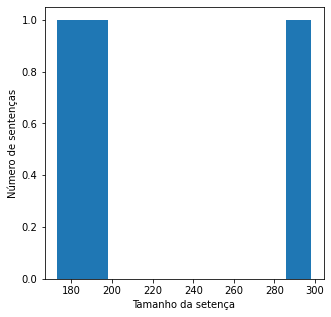

In [92]:
import matplotlib.pyplot as plt


#Distribuição das sentenças por quantidade de palavras 

fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()

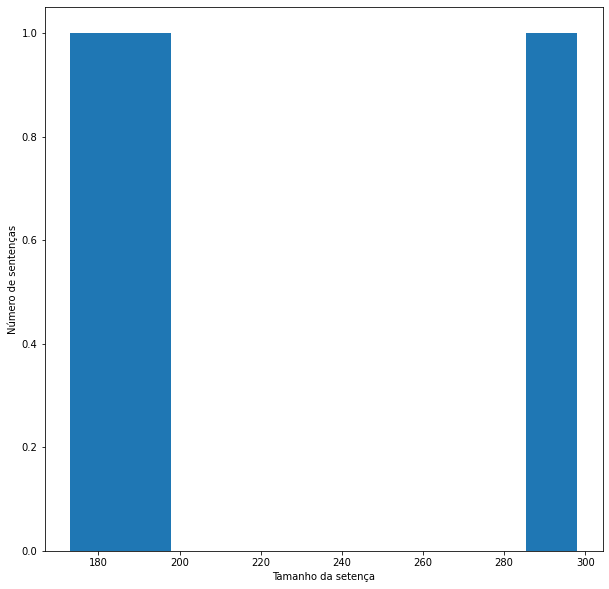

In [93]:
import matplotlib.pyplot as plt


#Distribuição das sentenças por quantidade de palavras 

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()

3. Lematização com a Lib stanza

In [12]:
import numpy as np
import stanza

In [96]:
# Preparando os dataframes 

tokens_list = clean_questions["tokens"].to_numpy().flatten()  # transforma toda a coluna do datafreme contentendo os tokens de cada sentença em um array
tokens_list = list(tokens_list)                               # converte o array para o formato list, gerando uma list de lists. 
print(tokens_list[0])                                         # teste para mostrar os tokens do primeiro documento carregado no dataframe
type(tokens_list[0])                                           # A lib stanza aceita que os tokens sejam passados dentro de uma lista



['câncer', 'pulmão', 'doença', 'maligna', 'comum', 'mundo', 'casos', 'câncer', 'câncer', 'pulmão', 'acordo', 'global', 'burden', 'of', 'disease', 'study', 'câncer', 'pulmão', 'principal', 'causa', 'mortalidade', 'câncer', 'milhões', 'mortes', 'ano', 'tipos', 'câncer', 'apresenta', 'taxa', 'mortalidade', 'padronizada', 'idade', 'mortes', 'habitantes', 'brasil', 'instituto', 'nacional', 'câncer', 'inca', 'estimou', 'casos', 'câncer', 'casos', 'neoplasia', 'maligna', 'primária', 'pulmão', 'câncer', 'pulmão', 'câncer', 'incidência', 'homens', 'câncer', 'incidência', 'mulheres', 'país', 'figura', 'países', 'câncer', 'pulmão', 'principal', 'causa', 'mortalidade', 'câncer', 'brasil', 'taxa', 'sobrevida', 'anos', 'padronizada', 'idade', 'país', 'semelhante', 'taxas', 'globais', 'variam', 'taxas', 'mortalidade', 'câncer', 'pulmão', 'padronizadas', 'idade', 'mortes', 'habitantes', 'mortes', 'habitantes', 'homens', 'mulheres', 'respectivamente', 'brasil', 'mortalidade', 'aumentou', 'mortes', 'hab

list

In [14]:
# Lematização

nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma', tokenize_pretokenized=True)
doc = nlp(tokens_list)
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

2022-05-18 17:20:01 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |

2022-05-18 17:20:01 INFO: Use device: cpu
2022-05-18 17:20:01 INFO: Loading: tokenize
2022-05-18 17:20:01 INFO: Loading: mwt
2022-05-18 17:20:01 INFO: Loading: pos
2022-05-18 17:20:02 INFO: Loading: lemma
2022-05-18 17:20:02 INFO: Done loading processors!


word: câncer 	lemma: câncer
word: pulmão 	lemma: pulmão
word: doença 	lemma: doença
word: maligna 	lemma: maligna
word: comum 	lemma: comum
word: mundo 	lemma: mundo
word: casos 	lemma: caso
word: câncer 	lemma: câncer
word: câncer 	lemma: câncer
word: pulmão 	lemma: pulmão
word: acordo 	lemma: acordo
word: global 	lemma: global
word: burden 	lemma: burden
word: of 	lemma: of
word: disease 	lemma: disease
word: study 	lemma: study
word: câncer 	lemma: câncer
word: pulmão 	lemma: pulmão
word: principal 	lemma: principal
word: causa 	lemma: causar
word: mortalidade 	lemma: mortalidade
word: câncer 	lemma: câncer
word: milhões 	lemma: milhão
word: mortes 	lemma: morte
word: ano 	lemma: ano
word: tipos 	lemma: tipo
word: câncer 	lemma: câncer
word: apresenta 	lemma: apresentar
word: taxa 	lemma: taxa
word: mortalidade 	lemma: mortalidade
word: padronizada 	lemma: padronizar
word: idade 	lemma: idade
word: mortes 	lemma: morte
word: habitantes 	lemma: habitante
word: brasil 	lemma: brasil
w

4. Implementar para determinar as seguintes informações dos resultados obtidos em 3:

4. <br>  1. Term Frequency (TF):
<br> 𝑇𝐹 = 𝑞𝑡𝑑 𝑑𝑒 𝑜𝑐𝑜𝑟𝑟ê𝑛𝑐𝑖𝑎 𝑑𝑜 𝑡𝑒𝑟𝑚𝑜 𝑒𝑚 𝑢𝑚 𝑡𝑒𝑥𝑡𝑜 / 𝑞𝑢𝑎𝑛𝑡𝑖𝑑𝑎𝑑𝑒 𝑡𝑜𝑡𝑎𝑙 𝑑𝑒 𝑝𝑎𝑙𝑎𝑣𝑟𝑎𝑠 𝑑𝑜 𝑡𝑒𝑥𝑡𝑜


In [15]:
import sklearn as sk
import math 

In [101]:
# teste: juntando as 3 listas que estavam dentro do array

import itertools
tokens_lists = clean_questions["tokens"].to_numpy().flatten() # transforma as lista de listas em um array contendo as 3 listas, 1 correspondente a cada texto

doc1 = tokens_lists[0]                                        # tokens to texto 1 no formato np.array
doc2 = tokens_lists[1]                                        # tokens to texto 2 no formato np.array
doc3 = tokens_lists[2]                                        # tokens to texto 3 no formato np.array

total = list(itertools.chain.from_iterable(tokens_lists))     # transforma o array em uma lista contendo todos os tokens de todos os documentos.

#len(total)                                                   # 668, significa que dentro de todo o conjunto temos 668 tokens. #WORDSET
#len(doc1)
docs = [doc1, doc2, doc3]
type(docs)                                                    # docList da função que calcula IDF
#docs
#test_total = set(total)                                       #
len(tokens_lists)


3

In [104]:
# teste: preparando os dados pra calcular o TF

wordDictA = dict.fromkeys(total, 0)                           # converte cada lista de tokens para o formato dict, armazenando a palavra como key, e a quantidade de vezes que ela se repete no documento como value.
wordDictB = dict.fromkeys(total, 0)
wordDictC = dict.fromkeys(total, 0)

for word in doc1:
    wordDictA[word]+=1
    
for word in doc2:
    wordDictB[word]+=1
    
for word in doc3:
    wordDictC[word]+=1
    
TF = pd.DataFrame([wordDictA, wordDictB, wordDictC])
TF

,câncer,pulmão,doença,maligna,comum,mundo,casos,acordo,global,burden,...,lobectomia,internacionais,revelaram,melhorar,espera,disseminação,técnicas,robótica,acelerem,processo
0,17,10,1,2,1,1,3,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,7,6,2,0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,4,0,0,0,0,2,1,0,0,...,1,1,1,1,1,1,1,1,1,1


In [105]:
# Função que calcula o TF 
def computeTF(wordDict, doc):
    tfDict = {}
    corpusCount = len(doc)
    for word, count in wordDict.items():
        tfDict[word] = count/float(corpusCount)
    return(tfDict)

# passando os documentos pela função que vai calcular o Term-Frequency (TF) em cada texto:

tfFirst = computeTF(wordDictA, doc1)
tfSecond = computeTF(wordDictB, doc2)
tfThird = computeTF(wordDictC, doc3)
# convertendo para o formato dataframe
tf = pd.DataFrame([tfFirst, tfSecond, tfThird])
tf

,câncer,pulmão,doença,maligna,comum,mundo,casos,acordo,global,burden,...,lobectomia,internacionais,revelaram,melhorar,espera,disseminação,técnicas,robótica,acelerem,processo
0,0.057047,0.033557,0.003356,0.006711,0.003356,0.003356,0.010067,0.003356,0.003356,0.003356,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.035533,0.030457,0.010152,0.000000,0.000000,0.000000,0.010152,0.005076,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.023121,0.023121,0.000000,0.000000,0.000000,0.000000,0.011561,0.005780,0.000000,0.000000,...,0.00578,0.00578,0.00578,0.00578,0.00578,0.00578,0.00578,0.00578,0.00578,0.00578


4.2. Document Frequency (DF):
<br> 𝐷𝐹 = 𝑞𝑡𝑑 𝑑𝑒 𝑜𝑐𝑜𝑟𝑟ê𝑛𝑐𝑖𝑎 𝑑𝑜 𝑡𝑒𝑟𝑚𝑜 𝑒𝑚 𝑢𝑚 𝑐𝑜𝑛𝑗𝑢𝑛𝑡𝑜 𝑑𝑒 𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡𝑜𝑠


In [106]:
wordDictTotal = dict.fromkeys(total,0)                            # Dicionário que vai armazenar a quantidade de ocorrrências de um termo em todos os documentos

for word in total:
    wordDictTotal[word] +=1

    
# Visualizando os dados dentro de um dataframe para verificar quantas vezes cada palavra se repete    
DF = pd.DataFrame([wordDictTotal])
DF
#print(wordDictTotal)



,câncer,pulmão,doença,maligna,comum,mundo,casos,acordo,global,burden,...,lobectomia,internacionais,revelaram,melhorar,espera,disseminação,técnicas,robótica,acelerem,processo
0,28,20,3,2,1,1,7,3,1,1,...,1,1,1,1,1,1,1,1,1,1


4.3. Inverse Document Frequency (IDF):
<br> 𝐼𝐷𝐹 = 𝑙𝑜𝑔(𝑞𝑡𝑑 𝑑𝑒 𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡𝑜𝑠 / (𝐷𝐹 + 1))


In [110]:
# Função para calcular o IDF

def computeIDF(docList):
    idfDict = {}

    N = len(docList)

    idf_dict_keys = [str(a) for a, b in docList[0].items()]
    idf_dict_values = [int(b) for a, b in docList[0].items()]

    idf_list = [(word, math.log10((N+1) / (val + 1)+1)) for word, val in zip(idf_dict_keys, idf_dict_values)]

    return(idf_list)

idfs = computeIDF([wordDictA, wordDictB, wordDictC])
IDFS = dict(idfs)                                   # convertendo para o formato dicionário para ser utilizado posteriormente
idfs = pd.DataFrame([IDFS])                         # visualizando dentro de um dataframe
idfs

#type(IDFS)

# Comentários:
# Para calcular o IDF é precisar calcular o logaritmo na base 10 da quantidade de documentos divididos pelo número de ocorrências daquela palavra + 1. 
# Problema: Assumo que não entendi direito como essa função funciona, wordDictA, wordDictB, wordDictC, são estrututras do tipo dicionário, cada uma correspondendo a um texto, dá pra ver que 
# cada palavra (key) carrega um número (value) o que essa função em teoria faz é pegar cada palavra, somar os values das palavras iguais e aplicar na expressão do IDF


,câncer,pulmão,doença,maligna,comum,mundo,casos,acordo,global,burden,...,lobectomia,internacionais,revelaram,melhorar,espera,disseminação,técnicas,robótica,acelerem,processo
0,0.08715,0.134699,0.477121,0.367977,0.477121,0.477121,0.30103,0.477121,0.477121,0.477121,...,0.69897,0.69897,0.69897,0.69897,0.69897,0.69897,0.69897,0.69897,0.69897,0.69897


4.4. TF-IDF:
<br> 𝑇𝐹 − 𝐼𝐷𝐹 = 𝐼𝐷𝐹 * 𝑇𝐹


In [111]:
# Função para calcular o TF-IDF
def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return(tfidf)
# passando os documento pelo IDF:
idfFirst = computeTFIDF(tfFirst, IDFS)             # doc 1
idfSecond = computeTFIDF(tfSecond, IDFS)           # doc 2
idfThird = computeTFIDF(tfThird, IDFS)             # doc 3
# inserindo em um dataframe
tfidf= pd.DataFrame([idfFirst, idfSecond, idfThird])
tfidf

,câncer,pulmão,doença,maligna,comum,mundo,casos,acordo,global,burden,...,lobectomia,internacionais,revelaram,melhorar,espera,disseminação,técnicas,robótica,acelerem,processo
0,0.004972,0.004520,0.001601,0.00247,0.001601,0.001601,0.003031,0.001601,0.001601,0.001601,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.003097,0.004102,0.004844,0.00000,0.000000,0.000000,0.003056,0.002422,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.002015,0.003114,0.000000,0.00000,0.000000,0.000000,0.003480,0.002758,0.000000,0.000000,...,0.00404,0.00404,0.00404,0.00404,0.00404,0.00404,0.00404,0.00404,0.00404,0.00404


4.5. Lista de strings com proximidade até 2 dos 5 termos de maior TF-IDF. Essas strings
devem ser acompanhadas de seu valor de TF. Exemplo: Suponha que a lista dos 5 termos de maior TF-IDF é [ casa, carro, comida, cachorro, gato]. Carro em um uma frase pode ter pneu e
banco com as palavras mais próximas. Em outra parte do texto, carro pode ter volante e cinto,
como as palavras mais próximas. Neste caso, para o termo carro, as strings [
pneu,banco,volante,cinto] são as que devem ser armazenadas para análise.

In [112]:
'''vocab = set(VOCAB)
type(vocab)'''

set

In [ ]:
'''# PREPROCESS


def compute_word_similarity(words):
    tc = IDFS

    def to_vec(w):
        vec = []
        for x in vocab:
            vec.append(tc[w][x])
        return vec

    for word in all_words:
        word_vec = to_vec(word)
        scores = []
        c = 0
        for k in tc.keys():
            if k == word: continue
            k_vec = to_vec(k)
            scores.append((self.cos_sim(word_vec, k_vec), k))
            c += 1
            # if  c > 10: break
        scores.sort(reverse=True)
        print("Top-5 matches for " + word + ": ", scores[:5])
        
compute_word_similarity(["câncer", "pulmão", "brasil", "saúde", "comum"])'''


5. Gerar um arquivo csv que possui todas as palavras de todos os documentos na primeira coluna,
em que cada linha é um token. Para cada token, informe nas colunas vizinhas as informações
determinadas no objetivo 4.1 até 4.4.

In [113]:
frames = [tf, DF, idfs, tfidf]
result = pd.concat(frames)
result                               # O resultado do merge de dataframes mostrou cada token como coluna e as demais informações como linhas, pra fazer com que os tokens virem linhas basta fazer a transposta desse df
df_t = result.T                      # Transforma as colunas no index
df_t.columns = ['TF doc1', 'TF doc2', 'TF doc3', 'DF', 'IDF', 'TF-IDF doc1', 'TF-IDF doc2', 'TF-IDF doc3'] # renomeando as colunas para melhor identificação
df_t


,TF doc1,TF doc2,TF doc3,DF,IDF,TF-IDF doc1,TF-IDF doc2,TF-IDF doc3
câncer,0.057047,0.035533,0.023121,28.0,0.087150,0.004972,0.003097,0.002015
pulmão,0.033557,0.030457,0.023121,20.0,0.134699,0.004520,0.004102,0.003114
doença,0.003356,0.010152,0.000000,3.0,0.477121,0.001601,0.004844,0.000000
maligna,0.006711,0.000000,0.000000,2.0,0.367977,0.002470,0.000000,0.000000
comum,0.003356,0.000000,0.000000,1.0,0.477121,0.001601,0.000000,0.000000
...,...,...,...,...,...,...,...,...
disseminação,0.000000,0.000000,0.005780,1.0,0.698970,0.000000,0.000000,0.004040
técnicas,0.000000,0.000000,0.005780,1.0,0.698970,0.000000,0.000000,0.004040
robótica,0.000000,0.000000,0.005780,1.0,0.698970,0.000000,0.000000,0.004040
acelerem,0.000000,0.000000,0.005780,1.0,0.698970,0.000000,0.000000,0.004040


In [114]:
df_t.to_csv(r'dataframe.csv', index = True) # cria um arquivo .csv dentro da pasta onde se encontra o notebook

6. Gerar nuvem de palavras para análise visual tal como exemplo abaixo. Cada ponto central será
um dos 5 termos de maior TF-IDF. As conexões são as palavras próximas obtidas em 4.5. O
tamanho do círculo da palavra é baseado no TF dela. O maior círculo que conecta o termo
central será normalizado para palavras de maior TF do conjunto.
![MarineGEO circle logo](https://i.imgur.com/gNv4V7l.png "MarineGEO logo")



**Tópicos de Auxílio**
<br>
<br>
<br>
Informações sobre as métricas utilizadas
<br>
https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
<br>
<br>
Atividade determinação da nuvem de palavras
<br>
https://www.kaggle.com/code/arthurtok/ghastly-network-and-d3-js-force-directed-graphs/notebook
<br>
http://andrewtrick.com/stormlight_network.html